# Weight mixing

This is a new kind of method to "train" models super fast without having to retrain the entire model again.

This method, introduced with the development of this mod, requires an overfitted model of your own dataset (in our case, `GPT-Neo-125M` combined with the AWSW data we extracted in step 1) + the pretrained model (`GPT-Neo-125M`).

Weight mixing essentialy involves 3 different steps, and can easily be done on CPU in mere seconds, if you manage to get the pretrained weights in advance:

 1. Generate samples from the base model (the model that came pretrained).
 
 2. Add a small amount of gaussian noise to a variable `s`.
 
 3. Do a linear interpolation between the base model and the main model (our own model) using `s` as a mask.
 
 4. Repeat generating samples on this interpolated model
 
     - Are the samples equal? Repeat from step 2.
     - Is even 1 sample different? Quit and move to step 5 (adding more noise to `s`).
   
 5. Now we have the portion that we know we can adjust without the model giving considerably different results. This is what we call the cold zone.
 
     - Using this new mask, we will linear interpolate between the base model and the main model given a user-specified `amount` and `cold_zone_diffusion_steps`.
     
     - `cold_zone_diffusion_steps` will "spread" noise slightly outside the cold zone by blurring, only affecting places that aren't used yet (i.e all the parts that are 0, the rest remains unchanged). The higher the value, the bigger area it will affect.
     
     - `amount` regulates the amount it'll transition between the main and base model.
    
**Note!** `cold_zone_diffusion_steps` can be skipped when not calling calculate_cold_zones, in this case we just do a simple linear interpolation between the 2 models.

In [1]:
%load_ext autoreload
%autoreload 2
import os
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForCausalLM
from model_manager import ModelManager
from model_mixing import ModelMixing
from model_utils import get_model
from config import Config
import matplotlib.pyplot as plt

In [2]:
saved_model_path = os.path.join("models", "awsw_main")
mixed_model_path = os.path.join("models", "awsw_mixed")
tokenizer = AutoTokenizer.from_pretrained('EleutherAI/gpt-neo-125M')
main_model = AutoModelForCausalLM.from_pretrained(saved_model_path)
base_model, _ = get_model("EleutherAI/gpt-neo-125M")
target_model, _ = get_model("EleutherAI/gpt-neo-125M")
device = torch.device('cpu')
target_model.eval()
model_manager = ModelManager(model=target_model, tokenizer=tokenizer, device=device)
print(f"Loaded base and main model to CPU")

Loaded base and main model to CPU


In [3]:
prompts = [
    ('<p><msg>c "Hey Remy!"<d><scn>park2<msg>Ry "Hey!"', "How are you?"),
    ('<p><msg>c "I was with Lorem today."<d><scn>park2<msg>Ad "Very nice."', "What do you think of Lorem?"),
    ('<p><msg>m "In Tatsu park, Adine and I sat down."', "Oh my god, Adine. What is this?"),
    ('<p><msg>m "I sat down on a chair in Anna\'s lab."', "What will we do here?"),
]

def sample_test(model_manager):
    for (past, prompt) in prompts:
        print(f"Prompt: {prompt}")
        reply = model_manager.say(past, prompt)
        print(f"Reply: {reply}")
        reply = model_manager.say(past, prompt, top_k = 50, top_p = 0.7)
        print(f"Reply [sampled]: {reply}")
        print("-" * 10)
sample_test(model_manager)

Prompt: How are you?
Reply: park2<msg>Ry "How are you?"<p><msg>c "How are you?"<d><scn>park2<msg>Ry "How are you?"<p><msg>c "How are you?"<d><scn>park2<msg>Ry "How are you?"<p><msg>c "How are you?"<d><scn>park2
Reply [sampled]: park2<msg>Remy<msg>Remy<scn>park2<msg>Remy<scn>park2<msg>Remy<scn>park2<msg>Remy<scn>park2<msg>Remy<scn>park2<msg>Remy<scn>park2<msg>Remy<scn>park2<msg
----------
Prompt: What do you think of Lorem?
Reply: park2<msg>Ad "Very nice."<p><msg>c "What do you think of Lorem?"<d><scn>park2<msg>Ad "Very nice."<p><msg>c "What do you think of Lorem?"<d><scn>park2<msg>Ad "Very nice."<p><msg>
Reply [sampled]: park2<msg>Ad "Very nice."<p><msg>c "What do you think of Lorem?"<d><scn>park2<msg>Ad "Very nice."<p><msg>c "What do you think of Lorem?"<d><scn>park2<msg>Ad "Very nice."<p><msg>
----------
Prompt: Oh my god, Adine. What is this?
Reply: c "Oh my god, Adine. What is this?"<d><scn>c "Oh my god, Adine. What is this?"<d><scn>c "Oh my god, Adine. What is this?"<d><scn>c "Oh 

In [4]:
model_mixing = ModelMixing(tokenizer, base_model, main_model, target_model, seed = 33)
model_mixing.calculate_cold_zones()

r1: (over with the employees."<p><msg>c "I know her, it's fine.") != r2(over with the city, I can't really say no to a social meeting with the chief of police)
r1: (over with the employees."<p><msg>c "I know her, it's fine.") != r2(over with the employees."<|endoftext|>)
r1: (hi."<|endoftext|>) != r2(hi, and I was the last person to see it."<|endoftext|>)
r1: (over with the employees."<p><msg>c "I know her, it's fine.") != r2(over with the employees."<|endoftext|>)
r1: (hi."<|endoftext|>) != r2(hi, and I was hoping that you could answer a few questions."<|endoftext|>)
r1: (over with the employees."<p><msg>c "I know her, it's fine.") != r2(over with the employees."<|endoftext|>)


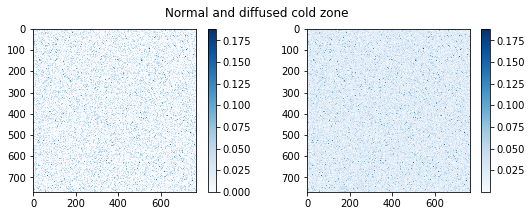

In [5]:
cold_zone = model_mixing.cold_zones[4]
fig, axs = plt.subplots(figsize=(9, 3), ncols=2)
fig.suptitle('Normal and diffused cold zone')
pos = axs[0].imshow(cold_zone, cmap='Blues', interpolation='nearest')
fig.colorbar(pos, ax=axs[0])
diffused_cold_zone = model_mixing.diffuse_cold_zone(model_mixing.cold_zones[4], 2)
pos = axs[1].imshow(diffused_cold_zone, cmap='Blues', interpolation='nearest')
fig.colorbar(pos, ax=axs[1])
plt.show()

In [6]:
model_mixing.mix(0.5, cold_zone_diffusion_steps = 2)
test_rps = [
    "Visit Lorem",
    "Meet with Lorem",
    "Visit Adine",
    "Fight Maverick",
    "Fight Adine",
    "Attack Adine"
]
for rp in test_rps:
    print(f'{rp} -> {model_manager.say("", rp, top_k = 50, top_p = 0.7)}')
    print("-" * 10)
sample_test(model_manager)

Visit Lorem -> loremapt<msg>Lo "Hey, [player_name]. I didn't even call you about the tests yet, but you told me you did."<|endoftext|>
----------
Meet with Lorem -> loremapt<msg>Lo "Hey [player_name]!"<|endoftext|>
----------
Visit Adine -> adineapt<msg>Ad "Hey [player_name]!"<|endoftext|>
----------
Fight Maverick -> black<msg>m "I didn't hesitate and kicked Maverick right in the stomach"<|endoftext|>
----------
Fight Adine -> cafe<msg>m "Adine barely avoids my attack, and I'm just about to go on a date with her again. I'm not sure if I could do that. I don't know how I could ever do that. I'm not sure what to think anymore."<|endoftext|>
----------
Attack Adine -> cafe<msg>Ad "I've been helping you for a while now. I just wanted to know if you're doing this right."<|endoftext|>
----------
Prompt: How are you?
Reply: park2<msg>Ry "I'm fine. I'm just a little busy."<p><msg>c "I'm not sure if I should take any visitors."<d><scn>park2<msg>Ry "No, I'm not going to be rude or anything. I j

In [7]:
target_model.save_pretrained(mixed_model_path)